In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
from jax import numpy as jnp
from jax.experimental import host_callback

from tqdm.auto import tqdm
from functools import partial
import optax
import matplotlib.pyplot as plt
from pprint import pprint

from flax import linen as nn
from typing import Sequence

from functools import partial
from typing import Callable, Sequence
from flax import struct
from flax import linen as nn
import jax
import jax.numpy as jnp
import optax
from functools import partial
import numpy as np

import actions
import qlearning
import replay
import plotting
from utils import ConvNet, Transition
from frozen_lake import EnvState, FrozenLake, ObsType, ActType, RNGKey

from mango_utils import MultiDQLTrainState
from mango_utils import eps_greedy_rollout, aggregate

In [6]:
jax.devices()

[cuda(id=0)]

In [7]:
seed = 42
map_size = 8
map_scale = int(jnp.log2(map_size))

# hyperparams
lr = 1e-3
max_interactions = 64 * 1000
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8

annealing_durations = [int(train_iter * n_rollouts * p) for p in [0.33, 0.33, 0.33]]
annealing_starts = jnp.cumsum(jnp.array([0] + annealing_durations[:-1]))
annealing_schedules = [
    optax.linear_schedule(1.0, 0.0, dur, start)
    for dur, start in zip(annealing_durations, annealing_starts)
]

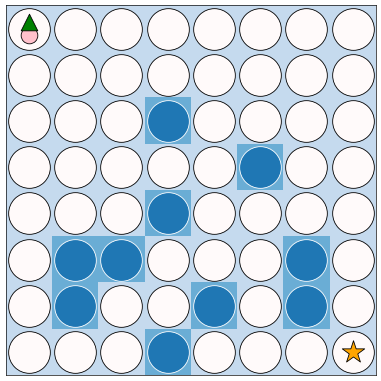

In [8]:
env = FrozenLake.make(None, (map_size, map_size))
env_state, obs = env.reset(jax.random.PRNGKey(0))
plotting.render(env, env_state)

In [9]:
n_actions = 5
n_layers = map_scale
rng = jax.random.PRNGKey(0)

MultiConvNet = nn.vmap(
    ConvNet,
    in_axes=None,
    variable_axes={"params": 0},
    split_rngs={"params": True},
    axis_size=n_actions,
)
MultiLayerConvNet = nn.vmap(
    MultiConvNet, in_axes=0, variable_axes={"params": 0}, split_rngs={"params": True}
)
cells = jnp.array([(2**i, 2**i) for i in reversed(range(1, map_scale + 1))])
dql_state = MultiDQLTrainState.create(
    rng,
    MultiLayerConvNet([8] * map_scale, n_actions),
    obs=jnp.stack([obs] * n_layers),
    beta_fn=partial(actions.beta_fn, cells),
)

2024-02-07 08:16:51.268142: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:810] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-02-07 08:16:51.268178: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:813] Conv: (f32[1,120,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,9,8,8]{3,2,1,0}, f32[120,3,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=3, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}


XlaRuntimeError: UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.1 = (f32[1,120,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,9,8,8]{3,2,1,0} %transpose, f32[120,3,3,3]{3,2,1,0} %transpose.1), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=3, custom_call_target="__cudnn$convForward", metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated[window_strides=(1, 1) padding=((1, 1), (1, 1)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=3 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/home/davide_sartor/MANGO-lite/jax/utils.py" source_line=39}, backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Original error: INTERNAL: All algorithms tried for (f32[1,120,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,9,8,8]{3,2,1,0}, f32[120,3,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=3, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} failed. Falling back to default algorithm.  Per-algorithm errors:
  Profiling failure on cuDNN engine eng28{k2=0,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng12{k5=1,k6=0,k7=1,k10=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng28{k2=3,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng28{k2=2,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng28{k2=4,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng28{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng12{k5=1,k6=0,k7=1,k10=1}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng34{k2=2,k4=1,k5=0,k6=0,k7=0,k19=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng34{k2=1,k4=1,k5=1,k6=0,k7=0,k19=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng1{k2=2,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng1{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng1{k2=4,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng34{k2=1,k4=3,k5=1,k6=0,k7=0,k19=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng34{k2=0,k4=2,k5=1,k6=0,k7=0,k19=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng34{k2=1,k4=2,k5=1,k6=0,k7=0,k19=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng53{k2=1,k13=0,k14=1,k18=0,k23=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng53{k2=1,k13=0,k14=3,k18=0,k23=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng53{k2=5,k13=1,k14=2,k18=0,k23=2}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng53{k2=1,k13=0,k14=3,k18=0,k23=2}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in external/xla/xla/stream_executor/cuda/cuda_dnn.cc(8105): 'status'

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.

In [10]:
epsilons = jnp.arange(map_scale)
transitions = eps_greedy_rollout(env, dql_state, rng, epsilons, 2)
replay_memory = replay.CircularBuffer.create(transitions)

NameError: name 'dql_state' is not defined

In [ ]:
from typing import NamedTuple


class Results(NamedTuple):
    eval_reward: jax.Array
    eval_done: jax.Array
    expl_reward: jax.Array
    expl_done: jax.Array


def loop_body(carry, rng_loop_iter):
    dql_state, replay_memory = carry
    # bind progress bar update host callback to rng_key split
    rng_expl, rng_train, rng_eval = host_callback.id_tap(
        lambda a, t: pbar.update(1), jax.random.split(rng_loop_iter, 3)
    )

    # exploration rollout
    epsilons = annealing_fn(dql_state.step)
    expl_transitions = eps_greedy_rollout(env, dql_state, rng_expl, epsilons, rollout_length)
    aggr_expl_transitions = aggregate(expl_transitions)
    replay_memory = replay_memory.push(aggr_expl_transitions)

    # policy training
    for rng_sample in jax.random.split(rng_train, train_iter):
        train_transitions = replay_memory.sample(rng_sample, rollout_length)
        dql_state = dql_state.update_params(train_transitions)

    # evaluation rollout
    eval_transitions = eps_greedy_rollout(
        env, dql_state, rng_eval, jnp.zeros_like(epsilons), rollout_length
    )

    # step results
    step_results = Results(
        eval_transitions.rewards,
        eval_transitions.done,
        expl_transitions.rewards,
        expl_transitions.done,
    )
    return (dql_state, replay_memory), step_results


pbar = tqdm(total=n_rollouts)
(dql_state, replay_memory), results = jax.lax.scan(
    f=loop_body,
    init=(dql_state, replay_memory),
    xs=jax.random.split(rng, n_rollouts),
)
pbar.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-02-07 00:48:18.742134: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to load in-memory CUBIN (compiled for a different GPU?).:CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to load in-memory CUBIN (compiled for a different GPU?).:CUDA_ERROR_OUT_OF_MEMORY: out of memory

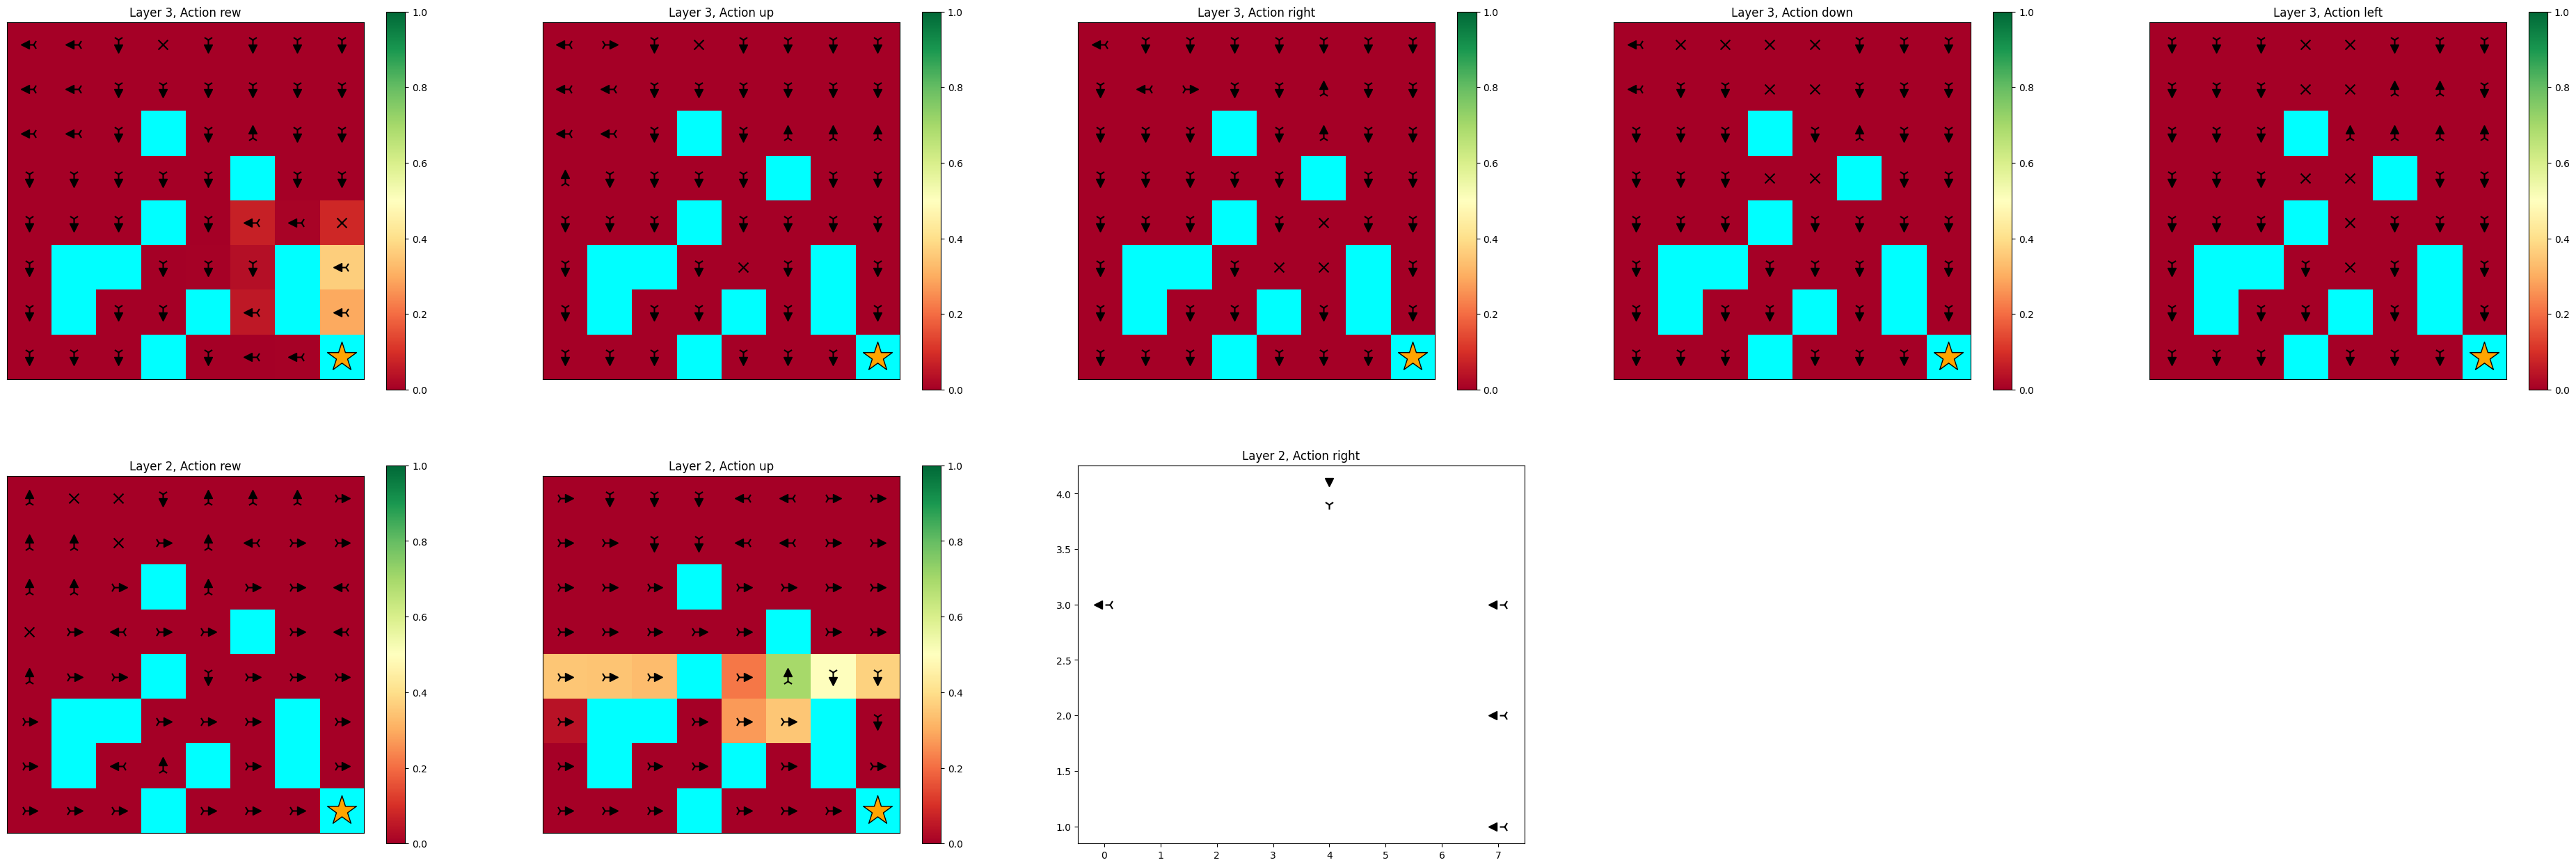

In [ ]:
plt.figure(figsize=((n_actions + 1) * map_size, n_layers * map_size))
for i in range(n_layers):
    for j in range(5):
        plt.subplot(n_layers, n_actions, i * n_actions + j + 1)
        plt.title(f'Layer {n_layers-i}, Action {["rew","up","right","down","left"][j]}')
        apply = lambda params, obs: dql_state.qval_apply_fn(
            params, jnp.repeat(obs[jnp.newaxis], n_layers, axis=0)
        )[i, 4 - j]
        plotting.plot_qvals(env, apply, dql_state.params_qnet, hold=True, autoscale=False)
plt.show()

transitions = eps_greedy_rollout(env, dql_state, rng, jnp.zeros_like(epsilons), rollout_length)
plotting.render(env, transitions.env_state)

In [ ]:
results.expl_done.sum()

Array(6279, dtype=int32)